In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from bempp_pbs.postprocess import PLOT_PARAMS, get_df

In [2]:
#PLOT_PARAMS['xtick.labelsize'] -= 2
#PLOT_PARAMS['ytick.labelsize'] -= 2
plt.rcParams.update(PLOT_PARAMS)   # update plot style

### Performance study using 1RCX

![1rcx_assembly](https://cdn.rcsb.org/images/structures/rc/1rcx/1rcx_assembly-1.jpeg)

### APBS results

- multigrid levels = 4

In [3]:
apbs_domain_size = np.array((224.1569, 224.1535, 197.5264))

In [4]:
apbs_data = {
    'ngrid': np.array([[289, 289, 257],
                       [385, 385, 353],
                       [513, 513, 481]]),
    'e_solv': np.array((-4.605294998128e+04, -4.553645046071e+04, -4.520005110484e+04)) / 4.184,  # kJ/mol -> kcal/mol
    'wall_time': np.array((164.10, 733.9, 6075)),
    'memory': np.array((5314604, 13040432, 34192120)) / 1e6, # kbytes -> Gbytes
}

**compute the grid spacing and refinement ratio**

Choosing a fixed refinement ratio for convergence study is tricky due to the restrictions of the choices of the grid size. After trials and errors, we ended up with the three mesh sizes listed above. We compute the grid spacing in each direction, and use the averaged value for computing the refinement ratio.

In [5]:
dx = apbs_domain_size / apbs_data['ngrid']
dx

array([[0.77562941, 0.77561765, 0.76858521],
       [0.58222571, 0.58221688, 0.55956487],
       [0.43695302, 0.43694639, 0.4106578 ]])

In [6]:
apbs_data['dx'] = dx.mean(axis=1)
apbs_data['dx']

array([0.77327742, 0.57466916, 0.42818574])

In [7]:
print('refinement ratio')
print(apbs_data['dx'][:2] / apbs_data['dx'][1:])

refinement ratio
[1.34560454 1.34210252]


In [8]:
r = np.mean(apbs_data['dx'][:2] / apbs_data['dx'][1:])
r

1.3438535280906585

**observed order of convergence**

In [9]:
def order_of_convergence(r, f1, f2, f3):
    """ f1, f2, f3: fine, medium, coarse """
    return np.log((f3-f2)/(f2-f1)) / np.log(r)

In [10]:
order_of_convergence(r, *apbs_data['e_solv'][::-1])

1.4508138578930458

**compute the extrapolated exact solution and the errors**

In [11]:
def richardson_extrapolation(f1, f2, f3):
    """ f1, f2, f3: fine, medium, coarse """
    return (f1*f3 - f2**2) / (f3 - 2*f2 + f1)

In [12]:
exact_apbs = richardson_extrapolation(*apbs_data['e_solv'][::-1])
print(exact_apbs)

-10652.894107108326


In [13]:
apbs_data['error'] = (apbs_data['e_solv']-exact_apbs) / exact_apbs
apbs_data['error']

array([0.03323276, 0.02164471, 0.01409733])

In [14]:
apbs_data['e_solv']

array([-11006.91921159, -10883.47286346, -10803.07148777])

**convergence plot**

In [15]:
N = np.prod(apbs_data['ngrid'], axis=1)
N

array([ 21464897,  52323425, 126584289])

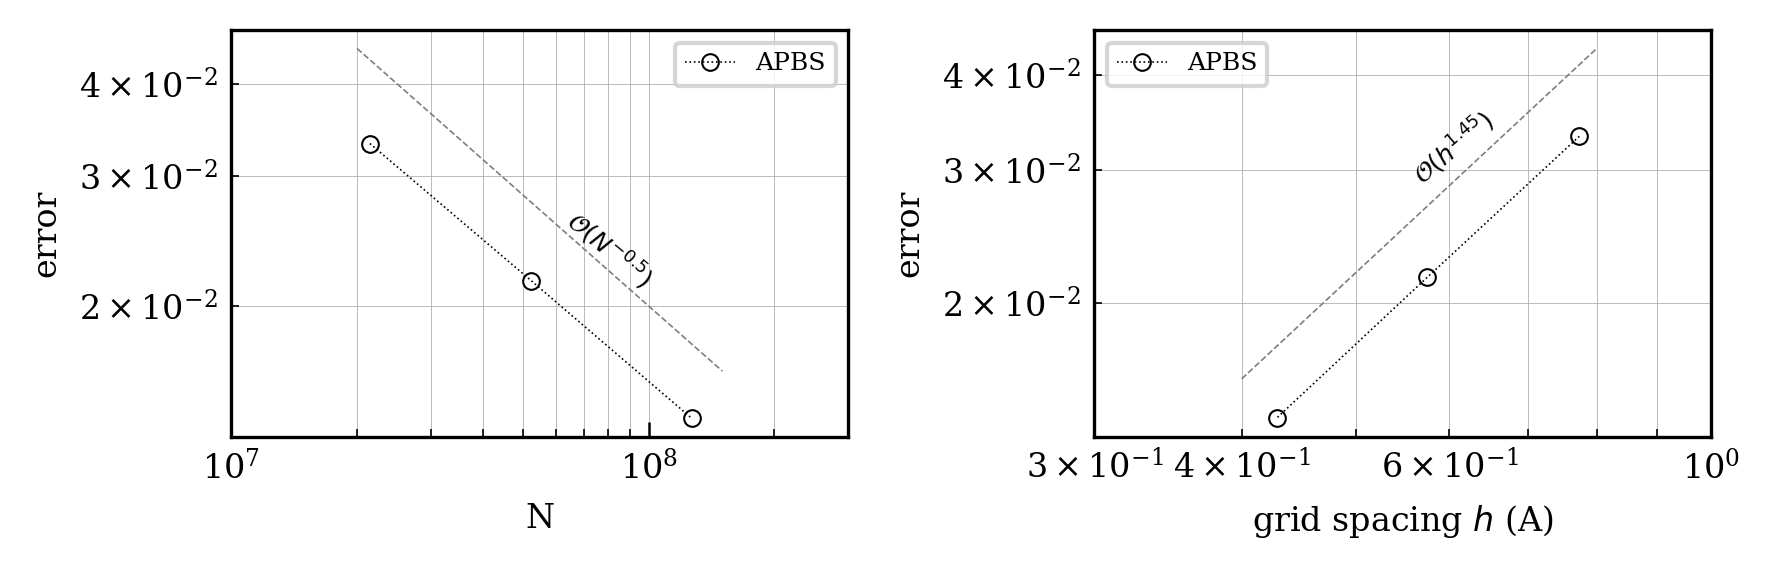

In [16]:
fig = plt.figure(figsize=(6, 2))
ax1 = fig.add_subplot(121)

N_ = np.array((2e7, 1.5e8))
asymp = 2e2 * np.power(N_, -0.5)
ax1.loglog(N, apbs_data['error'], linestyle='dotted', marker='o', fillstyle='none', color='black', label='APBS')
ax1.loglog(N_, asymp, linestyle='--', color='#7f7f7f')
ax1.grid(which="both")

ax1.set_xlim([1e7, 3e8])
ax1.set_xlabel('N')
ax1.set_ylabel('error')
ax1.legend()

loc = 6e7
text_loc = np.array((1.05*loc, 2e2 * np.power(loc, -0.5)))
ax1.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N^{-0.5})$', fontsize=6, rotation=-40, rotation_mode='anchor')

ax2 = fig.add_subplot(122)
h_ = np.array((0.4, 0.8))
asymp = 0.06 * np.power(h_, 1.45)
ax2.loglog(apbs_data['dx'], apbs_data['error'], linestyle='dotted', marker='o', fillstyle='none', color='black', label='APBS')
ax2.loglog(h_, asymp, linestyle='--', color='#7f7f7f')
ax2.grid(which="both")

ax2.set_xlim([0.3, 1.0])
ax2.set_xlabel('grid spacing $h$ (A)')
ax2.set_ylabel('error')
ax2.legend()

ax2.tick_params(axis='x', which='both', labelrotation=0)

loc = 0.6
text_loc = np.array((0.95*loc, 0.06 * np.power(loc, 1.45)))
ax2.text(text_loc[0], text_loc[1],r'$\mathcal{O}(h^{1.45})$', fontsize=6, rotation=40, rotation_mode='anchor')
plt.tight_layout()
# plt.savefig('../../tex/figs/5PTI_convergence.pdf', dpi=300);

**time and space complexity**

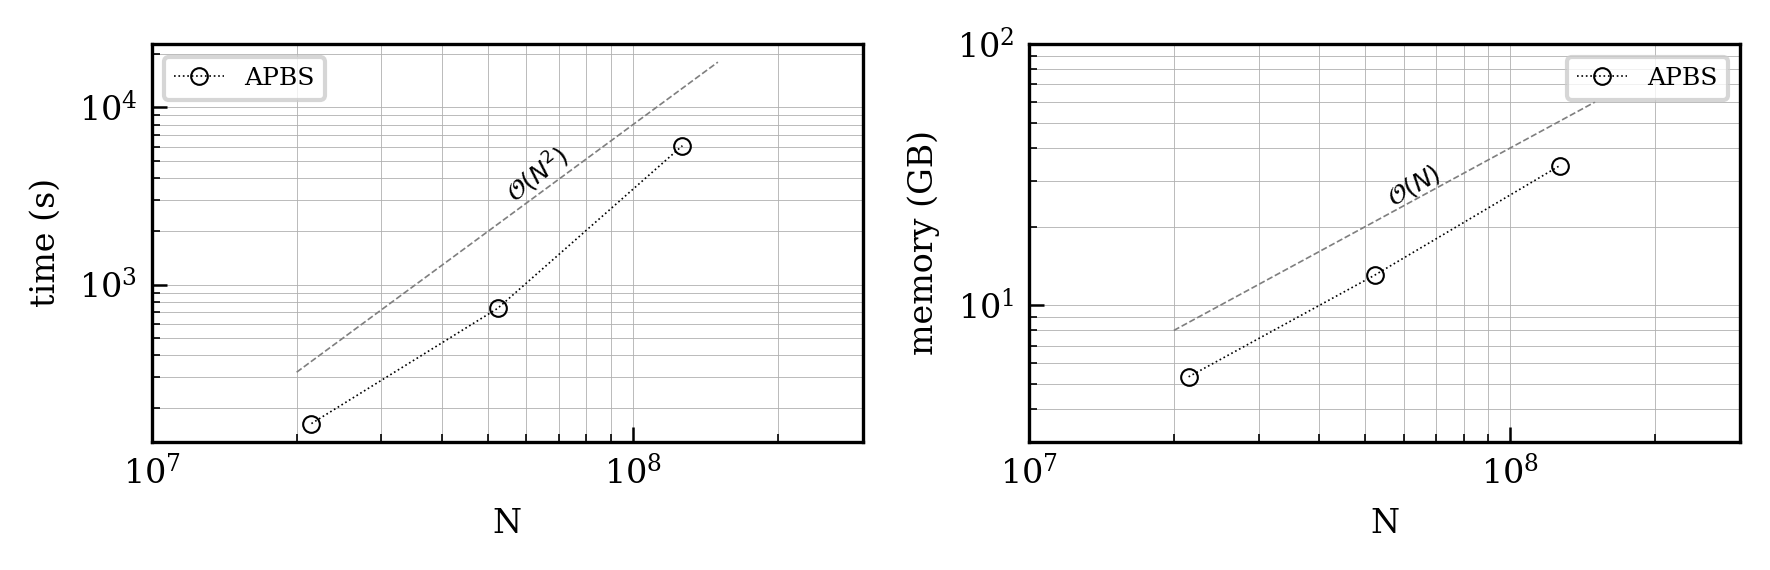

In [17]:
fig = plt.figure(figsize=(6, 2))
ax1 = fig.add_subplot(121)

N_ = np.array((2e7, 1.5e8))
asymp = 0.8e-12 * np.power(N_, 2)
ax1.loglog(N, apbs_data['wall_time'], linestyle='dotted', marker='o', fillstyle='none', color='black', label='APBS')
ax1.loglog(N_, asymp, linestyle='--', color='#7f7f7f')
ax1.grid(which="both")

ax1.set_xlim([1e7, 3e8])
ax1.set_xlabel('N')
ax1.set_ylabel('time (s)')
ax1.legend()

loc = 6e7
text_loc = np.array((0.95*loc, 0.8e-12 * np.power(loc, 2)))
ax1.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N^{2})$', fontsize=6, rotation=38, rotation_mode='anchor')

ax2 = fig.add_subplot(122)
N_ = np.array((2e7, 1.5e8))
asymp = 0.4e-6 * np.power(N_, 1)
ax2.loglog(N, apbs_data['memory'], linestyle='dotted', marker='o', fillstyle='none', color='black', label='APBS')
ax2.loglog(N_, asymp, linestyle='--', color='#7f7f7f')
ax2.grid(which="both")

ax2.set_xlim([1e7, 3e8])
ax2.set_ylim([3e0, 1e2])
ax2.set_xlabel('N')
ax2.set_ylabel('memory (GB)')
ax2.legend()

loc = 6e7
text_loc = np.array((0.95*loc, 0.4e-6 * np.power(loc, 1)))
ax2.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N)$', fontsize=6, rotation=30, rotation_mode='anchor')

plt.tight_layout()

### Bempp results

In [18]:
bempp_df = get_df('../runs/1RCX_performance/derivative_ex/', formulation='derivative', skip4=True)
bempp_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
237416,89.773381,138.854522,16,-11401.113779,4.439240,3.452312,16.361415,4.7963,65.163353,31.453362,18.910050,75.095706,0.131320,0.379271,13.395404
483796,166.863822,242.987282,16,-11139.842940,7.993596,6.367224,32.552647,7.2330,120.710951,47.690477,34.560891,135.507464,0.240006,0.684381,25.228450
962664,327.444365,478.534335,16,-11036.340906,15.283540,12.868627,63.245879,11.2960,240.033859,64.310824,74.066593,290.054870,0.514351,1.464924,50.102048
1943736,652.874650,782.074204,16,-10997.161398,30.073932,24.749161,127.078221,20.4800,480.567268,93.769271,123.908150,466.142955,0.860473,2.354257,98.253828


In [19]:
bempp_df['t_total_assembly']+bempp_df['t_total_gmres']

num_elem
237416      228.627902
483796      409.851103
962664      805.978700
1943736    1434.948855
dtype: float64

In [20]:
exact_bempp = richardson_extrapolation(*bempp_df['e_solv [kcal/Mol]'][-1:0:-1])
diff = np.abs((exact_bempp - exact_apbs) / exact_apbs)
print(f"{exact_bempp = }")
print(f"{exact_apbs  = }")
print(f"{diff = }")

exact_bempp = -10973.296759351277
exact_apbs  = -10652.894107108326
diff = 0.030076582853588697


In [21]:
bempp_df['error'] = np.abs((bempp_df['e_solv [kcal/Mol]'].values-exact_bempp) / exact_bempp)
bempp_df['error']

num_elem
237416     0.038987
483796     0.015177
962664     0.005745
1943736    0.002175
Name: error, dtype: float64

In [22]:
order_of_convergence(2, *bempp_df['e_solv [kcal/Mol]'][-1:0:-1])

1.4014879292315248

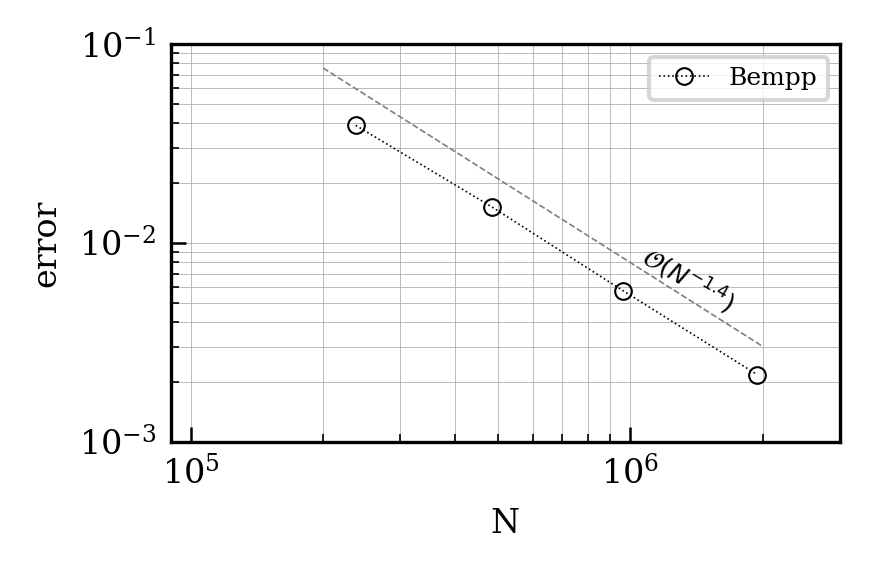

In [23]:
fig = plt.figure(figsize=(3, 2))
ax1 = fig.add_subplot(111)

N_ = np.array((2e5, 2e6))
asymp = 2e6 * np.power(N_, -1.4)
ax1.loglog(bempp_df.index, bempp_df.error, linestyle='dotted', marker='o', fillstyle='none', color='black', label='Bempp')
ax1.loglog(N_, asymp, linestyle='--', color='#7f7f7f')
ax1.grid(which="both")

ax1.set_xlim([9e4, 3e6])
ax1.set_ylim([1e-3, 1e-1])
ax1.set_xlabel('N')
ax1.set_ylabel('error')
ax1.legend()

loc = 1e6
text_loc = np.array((1.05*loc, 2e6 * np.power(loc, -1.4)))
ax1.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N^{-1.4})$', fontsize=6, rotation=-30, rotation_mode='anchor')
plt.tight_layout()

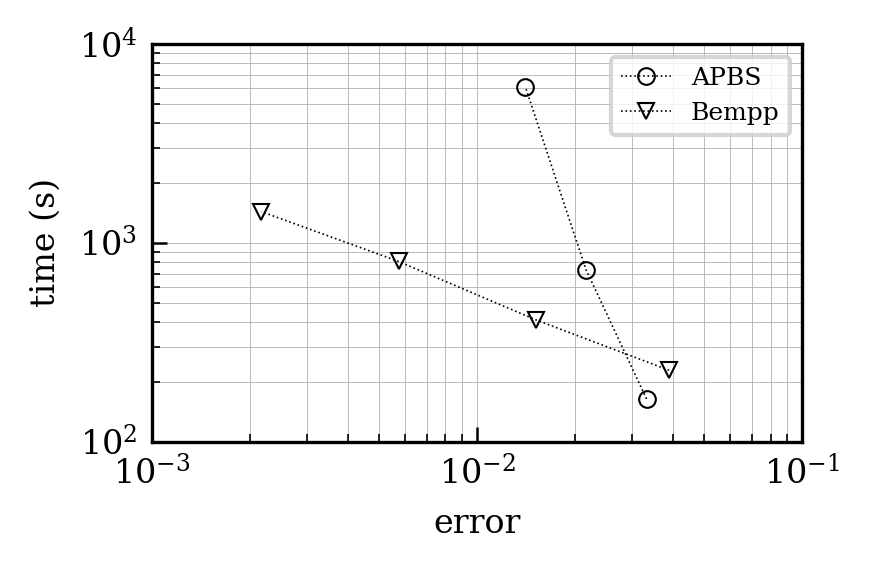

In [24]:
fig = plt.figure(figsize=(3, 2))
ax1 = fig.add_subplot(111)

ax1.loglog(apbs_data['error'], apbs_data['wall_time'], linestyle='dotted', marker='o', fillstyle='none', color='black', label='APBS')
ax1.loglog(bempp_df['error'], bempp_df['t_total_assembly']+bempp_df['t_total_gmres'], linestyle='dotted', marker='v', fillstyle='none', color='black', label='Bempp')
ax1.grid(which="both")

ax1.set_xlim([1e-3, 1e-1])
ax1.set_ylim([1e2, 1e4])
ax1.set_xlabel('error')
ax1.set_ylabel('time (s)')
ax1.legend()

plt.tight_layout()
#plt.savefig('../../tex/figs/time_performance_comparison.pdf', dpi=300);

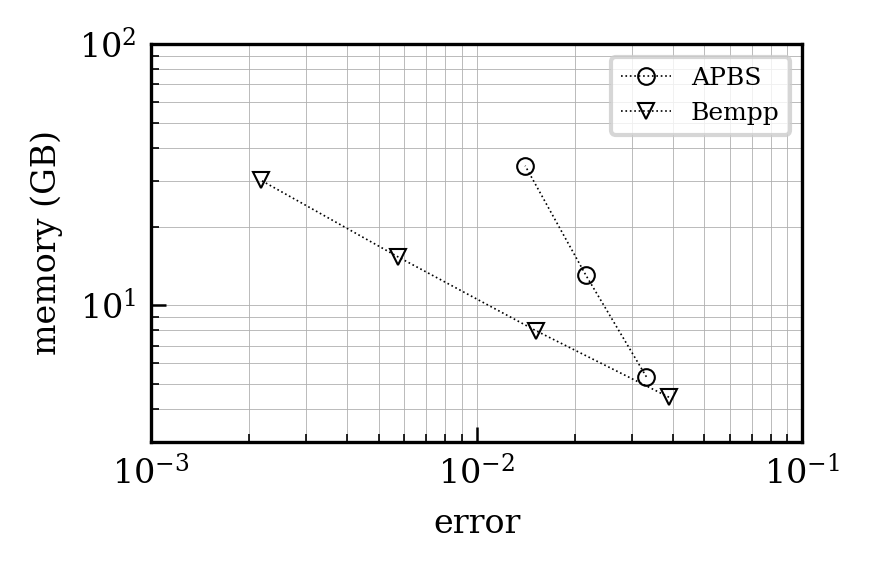

In [25]:
fig = plt.figure(figsize=(3, 2))

ax2 = fig.add_subplot(111)
ax2.loglog(apbs_data['error'], apbs_data['memory'], linestyle='dotted', marker='o', fillstyle='none', color='black', label='APBS')
ax2.loglog(bempp_df['error'], bempp_df['memory [GB]'], linestyle='dotted', marker='v', fillstyle='none', color='black', label='Bempp')
ax2.grid(which="both")

ax2.set_xlim([1e-3, 1e-1])
ax2.set_ylim([3e0, 1e2])
ax2.set_xlabel('error')
ax2.set_ylabel('memory (GB)')
ax2.legend()

plt.tight_layout()
#plt.savefig('../../tex/figs/memory_performance_comparison.pdf', dpi=300);